In [3]:
#!pip install requests beautifulsoup4 pandas tqdm transformers torch
!pip install PyMuPDF

In [5]:
import requests
import fitz  # PyMuPDF
import pandas as pd
from tqdm import tqdm
from datetime import datetime, time
import re
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
import torch
from google.colab import files


def construct_fomc_url(date):
    return f"https://www.federalreserve.gov/monetarypolicy/files/FOMC{date.strftime('%Y%m%d')}meeting.pdf"

def extract_text_from_pdf_url(url):
    try:
        r = requests.get(url)
        if r.status_code != 200:
            return None
        with open("temp.pdf", "wb") as f:
            f.write(r.content)
        text = ""
        with fitz.open("temp.pdf") as doc:
            for page in doc:
                text += page.get_text()
        os.remove("temp.pdf")
        return text.strip()
    except Exception as e:
        print(f" Error downloading {url}: {e}")
        return None

def get_fed_chair(date):
    if date < datetime(2014, 2, 1).date():
        return "Ben Bernanke"
    elif date < datetime(2018, 2, 1).date():
        return "Janet Yellen"
    else:
        return "Jerome Powell"

def clean_text(text):
    replacements = {
        "â€™": "'",
        "â€œ": '"',
        "â€": '"',
        "â€˜": "'",
        "â€“": "-",
        "â€”": "-",
        "â€¢": "*",
        "Ã©": "é",
        "Â": "",
        "\u200b": "",
    }
    for bad, good in replacements.items():
        text = text.replace(bad, good)
    return re.sub(r'\s+', ' ', text).strip()

def extract_session_text(full_text):
    # Look for session start line
    pattern = re.compile(r"Transcript of the Federal Open Market Committee Meeting on\s+[A-Za-z]+\s+\d{1,2}(?:–\d{1,2})?,\s+\d{4}.*?", re.DOTALL)
    match = pattern.search(full_text)
    if match:
        start_idx = match.start()
        return full_text[start_idx:]
    else:
        # fallback if session not found
        return full_text


# 2011–2019 conference dates
conference_dates = [
    "2011-04-27", "2011-06-22", "2011-08-09", "2011-09-21", "2011-11-02", "2011-12-13",
    "2012-01-25", "2012-03-13", "2012-04-25", "2012-06-20", "2012-08-01", "2012-09-13", "2012-10-24", "2012-12-12",
    "2013-01-30", "2013-03-20", "2013-05-01", "2013-06-19", "2013-07-31", "2013-09-18", "2013-10-30", "2013-12-18",
    "2014-01-29", "2014-03-19", "2014-04-30", "2014-06-18", "2014-07-30", "2014-09-17", "2014-10-29", "2014-12-17",
    "2015-01-28", "2015-03-18", "2015-04-29", "2015-06-17", "2015-07-29", "2015-09-17", "2015-10-28", "2015-12-16",
    "2016-01-27", "2016-03-16", "2016-04-27", "2016-06-15", "2016-07-27", "2016-09-21", "2016-11-02", "2016-12-14",
    "2017-02-01", "2017-03-15", "2017-05-03", "2017-06-14", "2017-07-26", "2017-09-20", "2017-11-01", "2017-12-13",
    "2018-01-31", "2018-03-21", "2018-05-02", "2018-06-13", "2018-08-01", "2018-09-26", "2018-11-08", "2018-12-19",
    "2019-01-30", "2019-03-20", "2019-06-19", "2019-07-31", "2019-09-18", "2019-10-30", "2019-12-11"
]

dates = [datetime.strptime(d, "%Y-%m-%d").date() for d in conference_dates]

records = []
for date in tqdm(dates):
    url = construct_fomc_url(date)
    raw_text = extract_text_from_pdf_url(url)
    if raw_text:
        session_text = extract_session_text(raw_text)
        cleaned = clean_text(session_text)
        records.append({
            "date": date,
            "datetime": datetime.combine(date, time(14, 30)),
            "chair": get_fed_chair(date),
            "url": url,
            "text": cleaned
        })
    else:
        print(f" {date} | PDF not found or unreadable")

df = pd.DataFrame(records)
df.to_csv("fomc_press_conferences_2011_2019_cleaned.csv", index=False)
files.download("fomc_press_conferences_2011_2019_cleaned.csv")
print(f"\nDone. Saved {len(df)} rows to fomc_press_conferences_2011_2019_cleaned.csv")


100%|██████████| 69/69 [00:55<00:00,  1.24it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Done. Saved 69 rows to fomc_press_conferences_2011_2019_cleaned.csv


In [7]:
print(df.columns.tolist())

['date', 'datetime', 'chair', 'url', 'text']


In [8]:
print(df.head())
print(df['text'].iloc[0])

         date            datetime         chair  \
0  2011-04-27 2011-04-27 14:30:00  Ben Bernanke   
1  2011-06-22 2011-06-22 14:30:00  Ben Bernanke   
2  2011-08-09 2011-08-09 14:30:00  Ben Bernanke   
3  2011-09-21 2011-09-21 14:30:00  Ben Bernanke   
4  2011-11-02 2011-11-02 14:30:00  Ben Bernanke   

                                                 url  \
0  https://www.federalreserve.gov/monetarypolicy/...   
1  https://www.federalreserve.gov/monetarypolicy/...   
2  https://www.federalreserve.gov/monetarypolicy/...   
3  https://www.federalreserve.gov/monetarypolicy/...   
4  https://www.federalreserve.gov/monetarypolicy/...   

                                                text  
0  Transcript of the Federal Open Market Committe...  
1  Transcript of the Federal Open Market Committe...  
2  Transcript of the Federal Open Market Committe...  
3  Transcript of the Federal Open Market Committe...  
4  Transcript of the Federal Open Market Committe...  
Transcript of the Federal 

In [ ]:
# import pandas as pd
# from tqdm import tqdm
# import torch

# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from torch.nn.functional import softmax


# # # ========== Step 1: Load Cleaned Transcript Data ==========
# # df = pd.read_csv("fomc_cleaned_transcripts.csv")  # must contain 'date' and 'text' columns
# # df['date'] = pd.to_datetime(df['date'])

# # ========== Step 1: Load Cleaned Transcript Data ==========
# input_path = "/content/fomc_press_conferences_2011_2019_cleaned.csv"
# output_path = "/content/fomc_sliding_window_sentiment.csv"
# #/content/fomc_press_conferences_2011_2019_cleaned.csv
# df = pd.read_csv(input_path)
# df['date'] = pd.to_datetime(df['date'])


# # ========== Step 2: Load FinBERT ==========
# model_name = "yiyanghkust/finbert-tone"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)
# model.eval()

# # ========== Step 3: Sliding Window Chunking ==========
# def sliding_window_chunks(text, window_size=512, stride=256):
#     tokens = tokenizer.tokenize(text)
#     chunks = []
#     for i in range(0, len(tokens), stride):
#         chunk = tokens[i:i + window_size]
#         if chunk:
#             chunks.append(tokenizer.convert_tokens_to_string(chunk))
#         if i + window_size >= len(tokens):
#             break
#     return chunks

# # ========== Step 4: Get Sentiment from FinBERT ==========
# def get_sentiment_score(chunk):
#     inputs = tokenizer(chunk, return_tensors="pt", truncation=True, max_length=512)
#     with torch.no_grad():
#         outputs = model(**inputs)
#         probs = softmax(outputs.logits, dim=1).squeeze()
#     label = ["negative", "neutral", "positive"][torch.argmax(probs).item()]
#     return label, probs.tolist()

# # ========== Step 5: Loop Over Rows, Apply Sliding Sentiment ==========
# results = []

# for date, group in tqdm(df.groupby("date"), desc="Processing transcripts by date"):
#     for i, row in group.iterrows():
#         text = row["text"]
#         chunks = sliding_window_chunks(text)
#         for idx, chunk in enumerate(chunks):
#             try:
#                 label, prob = get_sentiment_score(chunk)
#                 results.append({
#                     "date": date,
#                     "chunk_id": idx,
#                     "chunk_text": chunk,
#                     "sentiment": label,
#                     "neg_prob": prob[0],
#                     "neu_prob": prob[1],
#                     "pos_prob": prob[2],
#                 })
#             except Exception as e:
#                 print(f"Error on date {date} chunk {idx}: {e}")
#                 continue

# # ========== Step 6: Save Output ==========
# sentiment_df = pd.DataFrame(results)
# sentiment_df.to_csv("fomc_sliding_window_sentiment.csv", index=False)
# print("✅ Sentiment extraction complete and saved.")


In [9]:
print(df.head())

         date            datetime         chair  \
0  2011-04-27 2011-04-27 14:30:00  Ben Bernanke   
1  2011-06-22 2011-06-22 14:30:00  Ben Bernanke   
2  2011-08-09 2011-08-09 14:30:00  Ben Bernanke   
3  2011-09-21 2011-09-21 14:30:00  Ben Bernanke   
4  2011-11-02 2011-11-02 14:30:00  Ben Bernanke   

                                                 url  \
0  https://www.federalreserve.gov/monetarypolicy/...   
1  https://www.federalreserve.gov/monetarypolicy/...   
2  https://www.federalreserve.gov/monetarypolicy/...   
3  https://www.federalreserve.gov/monetarypolicy/...   
4  https://www.federalreserve.gov/monetarypolicy/...   

                                                text  
0  Transcript of the Federal Open Market Committe...  
1  Transcript of the Federal Open Market Committe...  
2  Transcript of the Federal Open Market Committe...  
3  Transcript of the Federal Open Market Committe...  
4  Transcript of the Federal Open Market Committe...  


In [10]:
# df = pd.read_csv("/content/fomc_press_conferences_2011_2019_cleaned.csv")
# df['date'] = pd.to_datetime(df['date'])
print(df['text'].iloc[0])

Transcript of the Federal Open Market Committee Meeting on April 26–27, 2011 April 26 Session CHAIRMAN BERNANKE. Good morning, everybody. Welcome to the marathon FOMC meeting. [Laughter] Thank you for accommodating the early start. As you know, we have an extra go-round today. I hope this will not be the norm, but we’ll just have to see how things evolve. Given the topics this morning, I thought we would make this a joint FOMC–Board meeting, and so I need a motion to close the meeting. MS. YELLEN. So moved. CHAIRMAN BERNANKE. Thank you. Without objection. Let’s begin, as usual, with financial developments and open market operations, and I’ll turn to Brian Sack. Brian. MR. SACK. 1 [Footnote 1. The materials used by Mr. Sack are appended to this transcript (appendix 1). End of footnote 1.] Thank you, Mr. Chairman. It was a complicated intermeeting period in financial markets, as investors had to contend with several significant global developments affecting risk sentiment, with domestic 

In [12]:


# -----------------------------
# Load FOMC Data
# -----------------------------
df = pd.read_csv("/content/fomc_press_conferences_2011_2019_cleaned.csv")
df['date'] = pd.to_datetime(df['date'])

# -----------------------------
# Load FinBERT Model
# -----------------------------
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

# -----------------------------
# Get Chair by Date
# -----------------------------
def get_chair_name(date):
    if date < datetime(2014, 2, 1):
        return "CHAIRMAN BERNANKE"
    elif date < datetime(2018, 2, 1):
        return "CHAIR YELLEN"
    else:
        return "CHAIR POWELL"

# -----------------------------
# Chunking Function
# -----------------------------
def sliding_window_chunks(text, window_size=512, stride=256):
    tokens = tokenizer.tokenize(text)
    chunks = []
    for i in range(0, len(tokens), stride):
        chunk = tokens[i:i + window_size]
        if chunk:
            chunks.append((i, tokenizer.convert_tokens_to_string(chunk)))
        if i + window_size >= len(tokens):
            break
    return chunks

# -----------------------------
# Sentiment Scoring
# -----------------------------
def get_sentiment_score(chunk):
    inputs = tokenizer(chunk, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = softmax(outputs.logits, dim=1).squeeze()
    return ["negative", "neutral", "positive"][torch.argmax(probs).item()], probs.tolist()

# -----------------------------
# Resume from Previous Run
# -----------------------------
output_path = "/content/fomc_weighted_sentiment_scores.csv"
processed_dates = set()

if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    existing['date'] = pd.to_datetime(existing['date'])
    processed_dates = set(existing['date'].dt.date)
    print(f"🔁 Resuming: {len(processed_dates)} dates already processed.")
else:
    with open(output_path, "w") as f:
        f.write("date,chair,sentiment_score\n")

# -----------------------------
# Process Incrementally
# -----------------------------
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing FOMC transcripts"):
    date = row['date'].date()

    if date in processed_dates:
        continue

    text = row['text']
    chair_name = get_chair_name(row['date'])

    match = re.search(chair_name, text.upper())
    if not match:
        continue

    chair_text = text[match.start():]
    indexed_chunks = sliding_window_chunks(chair_text)

    if not indexed_chunks:
        continue

    texts_for_tfidf = [c[1] for c in indexed_chunks]
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts_for_tfidf)
    tfidf_scores = tfidf_matrix.sum(axis=1).A1
    total_tfidf = tfidf_scores.sum()
    tfidf_weights = tfidf_scores / total_tfidf if total_tfidf > 0 else np.ones(len(tfidf_scores)) / len(tfidf_scores)

    all_scores = []
    for i, (chunk_idx, chunk_text) in enumerate(indexed_chunks):
        try:
            _, probs = get_sentiment_score(chunk_text)
            pos_weight = max(1 - (i / len(indexed_chunks)), 0.1)
            final_weight = tfidf_weights[i] * pos_weight
            all_scores.append({
                'neg_prob': probs[0],
                'neu_prob': probs[1],
                'pos_prob': probs[2],
                'weight': final_weight
            })
        except Exception as e:
            print(f"⚠️ Error processing chunk {i} on {date}: {e}")
            continue

    if not all_scores:
        continue

    score_df = pd.DataFrame(all_scores)
    score_df['weighted_sentiment'] = score_df['pos_prob'] * 1 + score_df['neu_prob'] * 0 + score_df['neg_prob'] * -1
    weighted_sum = np.average(score_df['weighted_sentiment'], weights=score_df['weight'])

    with open(output_path, "a") as f:
      f.write(f"{row['date'].date()},{chair_name},{weighted_sum}\n")

    # Optional: Download incrementally (Google Colab only)
    # from google.colab import files
    # try:
    #     files.download(output_path)
    # except Exception as e:
    #     print(f"📂 Download failed (but file saved): {e}")



#files.download("fomc_press_conferences_2011_2019_cleaned.csv")


🔁 Resuming: 1 dates already processed.


Processing FOMC transcripts:   0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Processing FOMC transcripts:   3%|▎         | 2/69 [01:20<45:07, 40.42s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Processing FOMC transcripts:   4%|▍         | 3/69 [02:10<48:34, 44.16s/it]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Processing FOMC transcripts:   6%|▌         | 4/69 [03:42<1:

In [14]:
#print(sentiment_df.columns.tolist())
files.download(output_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2515988940.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start=start, end=end, interval="1d", progress=False)[['Close']].rename(columns={'Close': 'sp500'})
/tmp/ipython-input-2515988940.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start=start, end=end, interval="1d", progress=False)[['Close']].rename(columns={'Close': 'vix'})


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📌 Regression: Abnormal Return (Weighted Score)
                             OLS Regression Results                            
Dep. Variable:        abnormal_return   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     3.852
Date:                Thu, 07 Aug 2025   Prob (F-statistic):             0.0542
Time:                        20:42:55   Log-Likelihood:                 201.13
No. Observations:                  64   AIC:                            -398.3
Df Residuals:                      62   BIC:                            -393.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

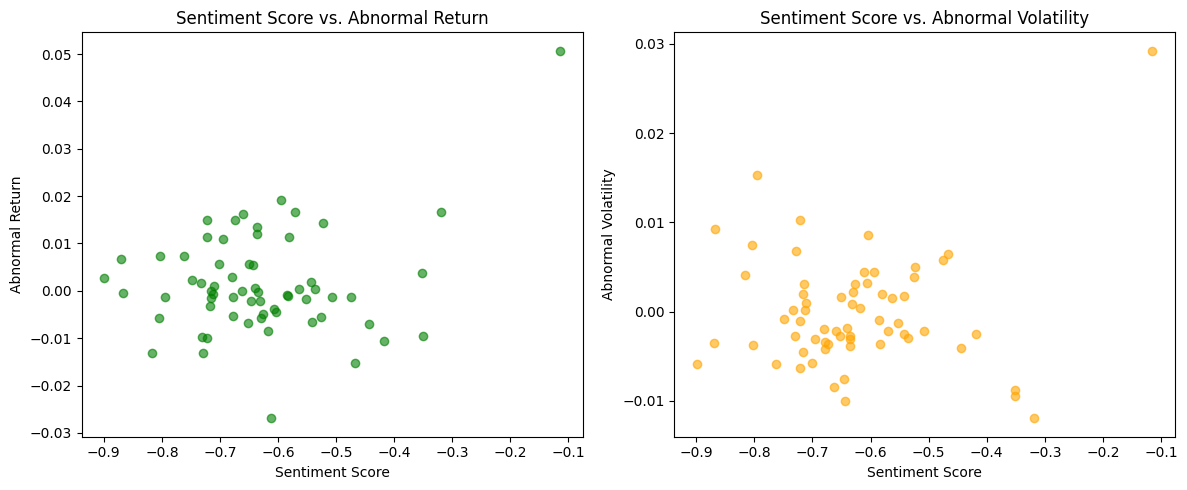

In [15]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from datetime import timedelta
import matplotlib.pyplot as plt
from google.colab import files

# ------------------------
# Load Sentiment Data (already weighted & aggregated)
# ------------------------
sentiment_df = pd.read_csv("/content/fomc_weighted_sentiment_scores.csv", parse_dates=['date'])

# ------------------------
# Get Market Data
# ------------------------
start = sentiment_df['date'].min() - timedelta(days=120)
end = sentiment_df['date'].max() + timedelta(days=120)

sp500 = yf.download("^GSPC", start=start, end=end, interval="1d", progress=False)[['Close']].rename(columns={'Close': 'sp500'})
vix = yf.download("^VIX", start=start, end=end, interval="1d", progress=False)[['Close']].rename(columns={'Close': 'vix'})

# Compute returns
market = pd.concat([sp500, vix], axis=1).dropna()
market['sp500_return'] = market['sp500'].pct_change()
market['vix_return'] = market['vix'].pct_change()
market = market.reset_index().rename(columns={'Date': 'date'})

# ------------------------
# Abnormal Return / Volatility Calculation
# ------------------------
def calc_abnormal_features(row, market_df):
    event_date = row['date']
    before = market_df[(market_df['date'] >= event_date - timedelta(days=60)) & (market_df['date'] < event_date)]
    after = market_df[(market_df['date'] > event_date) & (market_df['date'] <= event_date + timedelta(days=5))]

    avg_past_return = before['sp500_return'].mean()
    avg_past_vol = before['sp500_return'].std()

    event_row = market_df[market_df['date'] == event_date]
    event_return = event_row['sp500_return'].values[0] if not event_row.empty else np.nan

    abn_return = event_return - avg_past_return
    abn_vol = after['sp500_return'].std() - avg_past_vol

    return pd.Series({
        'abnormal_return': abn_return,
        'abnormal_volatility': abn_vol
    })

abn_features = sentiment_df.apply(lambda row: calc_abnormal_features(row, market), axis=1)
final_df = pd.concat([sentiment_df, abn_features], axis=1).dropna()

final_df.to_csv("final_df.csv", index=False)
files.download("final_df.csv")


# ------------------------
# Run Regressions
# ------------------------
def run_regression(y, X, label):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(f"\n📌 Regression: {label}\n", model.summary())

run_regression(final_df['abnormal_return'], final_df[['sentiment_score']], 'Abnormal Return (Weighted Score)')
run_regression(final_df['abnormal_volatility'], final_df[['sentiment_score']], 'Abnormal Volatility (Weighted Score)')

# ------------------------
# Visualization
# ------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(final_df['sentiment_score'], final_df['abnormal_return'], color='green', alpha=0.6)
plt.title('Sentiment Score vs. Abnormal Return')
plt.xlabel('Sentiment Score')
plt.ylabel('Abnormal Return')

plt.subplot(1, 2, 2)
plt.scatter(final_df['sentiment_score'], final_df['abnormal_volatility'], color='orange', alpha=0.6)
plt.title('Sentiment Score vs. Abnormal Volatility')
plt.xlabel('Sentiment Score')
plt.ylabel('Abnormal Volatility')

plt.tight_layout()
plt.show()


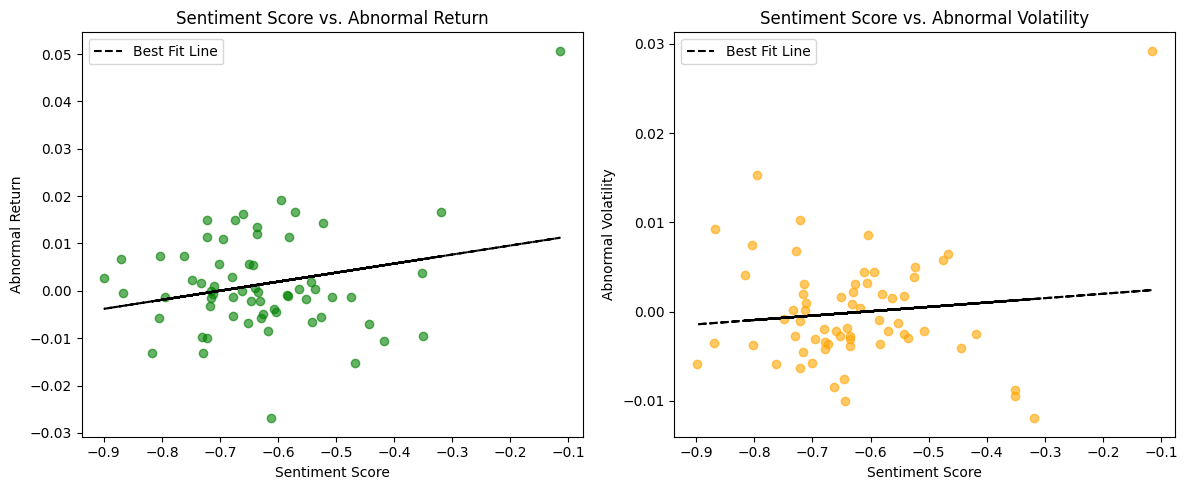

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------
# Visualization with Best Fit Line
# ------------------------
plt.figure(figsize=(12, 5))

# ---- Subplot 1: Sentiment vs Abnormal Return ----
plt.subplot(1, 2, 1)
x1 = final_df['sentiment_score']
y1 = final_df['abnormal_return']
plt.scatter(x1, y1, color='green', alpha=0.6)

# Best fit line
m1, b1 = np.polyfit(x1, y1, 1)
plt.plot(x1, m1 * x1 + b1, color='black', linestyle='--', label='Best Fit Line')

plt.title('Sentiment Score vs. Abnormal Return')
plt.xlabel('Sentiment Score')
plt.ylabel('Abnormal Return')
plt.legend()

# ---- Subplot 2: Sentiment vs Abnormal Volatility ----
plt.subplot(1, 2, 2)
x2 = final_df['sentiment_score']
y2 = final_df['abnormal_volatility']
plt.scatter(x2, y2, color='orange', alpha=0.6)

# Best fit line
m2, b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2 * x2 + b2, color='black', linestyle='--', label='Best Fit Line')

plt.title('Sentiment Score vs. Abnormal Volatility')
plt.xlabel('Sentiment Score')
plt.ylabel('Abnormal Volatility')
plt.legend()

plt.tight_layout()
plt.show()
